## Многоклассовая классификация

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import re
from sklearn.neighbors import KNeighborsClassifier

Загрузка базы данных

In [2]:
df = pd.read_csv('complaints.csv')
df.shape

(1632105, 18)

In [3]:
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821


In [4]:
pd.DataFrame(df.Product.unique())

,0
0,Debt collection
1,"Credit reporting, credit repair services, or o..."
2,Vehicle loan or lease
3,Credit card or prepaid card
4,"Money transfer, virtual currency, or money ser..."
5,Student loan
6,Mortgage
7,Checking or savings account
8,"Payday loan, title loan, or personal loan"
9,Credit card


Удалими данные неподходящие для данной задачи

In [5]:
# Создаем новую базу данных с 2 столбцами
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Удаляем пустые значения
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Переименуем 2 столбец для простого осозания
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(545262, 2)

In [6]:
df1.head(7)

,Product,Consumer_complaint
0,Debt collection,transworld systems inc. \nis trying to collect...
2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
3,Debt collection,"Over the past 2 weeks, I have been receiving e..."
5,"Credit reporting, credit repair services, or o...",XXXX Disputed XXXX incorrect last date of acti...
10,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
11,Debt collection,While checking my credit report I noticed thre...
13,Debt collection,I received an email from a XXXX XXXX along wit...


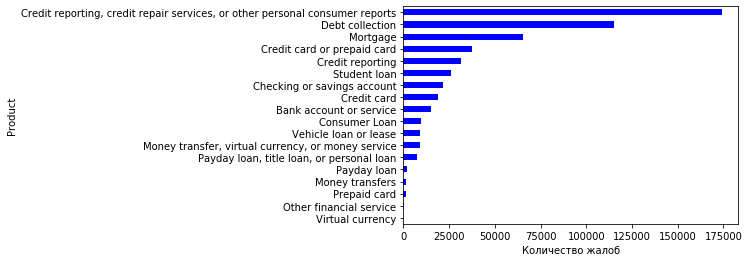

In [7]:
fig = plt.figure()
df1.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color='blue')
plt.xlabel('Количество жалоб', fontsize = 10);

In [8]:
df1.Consumer_complaint.count()

545262

Объединение классов

In [9]:
dd = df1
dd.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports' : 'Credit reporting or other',
             'Mortgage': 'Loans or other', 
             'Payday loan, title loan, or personal loan': 'Loans or other',
             'Payday loan': 'Loans or other',
             'Student loan': 'Loans or other',
             'Vehicle loan or lease': 'Loans or other',
             'Consumer Loan' : 'Loans or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Money transfers': 'Bank account or service',
             'Virtual currency': 'Bank account or service',
             'Other financial service': 'Bank account or service',
             'Credit reporting': 'Credit reporting or other',
             'Checking or savings account': 'Bank account or service',
             'Money transfer, virtual currency, or money service': 'Bank account or service'
             }}, 
            inplace= True)
pd.DataFrame(dd.Product.unique())

,0
0,Debt collection
1,Credit reporting or other
2,Bank account or service
3,Loans or other
4,Credit card or prepaid card


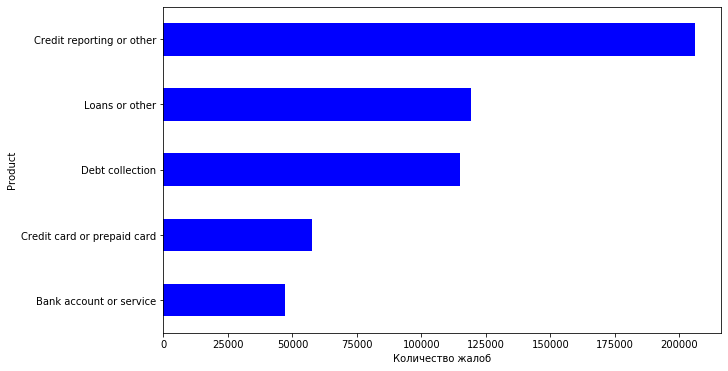

In [10]:
fig = plt.figure(figsize=(10,6))
dd.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color='blue')
plt.xlabel('Количество жалоб', fontsize = 10);

In [11]:
dd['category_id'] = dd['Product'].factorize()[0]
category_id_df = dd[['Product', 'category_id']].drop_duplicates()


category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# Новая база данных
dd.head(8)

,Product,Consumer_complaint,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,Credit reporting or other,I would like to request the suppression of the...,1
3,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
5,Credit reporting or other,XXXX Disputed XXXX incorrect last date of acti...,1
10,Bank account or service,"I was sold access to an event digitally, of wh...",2
11,Debt collection,While checking my credit report I noticed thre...,0
13,Debt collection,I received an email from a XXXX XXXX along wit...,0
16,Loans or other,"Over a week ago, I started trying to get my es...",3


In [12]:
df2 = dd.sample(20000, random_state=1).copy()

In [13]:
df2.head()

,Product,Consumer_complaint,category_id
265490,Credit reporting or other,To : Whom It May concern : I am writing to dis...,1
908781,Credit reporting or other,I show that all credit reporting companies are...,1
173815,Credit reporting or other,XXXX sold this information to the credit burea...,1
1352742,Debt collection,My wife and I cancelled XXXX because they chan...,0
615682,Debt collection,There have been several accounts that have bee...,0


In [14]:
df2['Consumer_complaint'][1352742]

'My wife and I cancelled XXXX because they changed our rates without warning when we had a set amount we were paying and tried to bill us for a coaxial product. We moved from XXXX XXXX XXXX in XXXX, Montana to XXXX XXXX XXXX XXXX, XXXX, Montana. We had used there free move program in the past and everything went smooth but this time they tried to charge us for coax that we already had at old house and could have taken or we could have but they never mentioned it and that I also had plenty of new to use. We were not under any contract. I spoke to XXXX before they turned this over to collections and i was told this was closed. We ended up turning our service off prior to coming to a resolution with XXXX and we now use XXXX. XXXX tried to say we signed a new contract upon installation at our new home but I told them that was not true and they said they were documenting this. At a, later date I contacted them about this and they said we signed something on the installers electronic device.

In [15]:
arr = df2['Consumer_complaint'].values
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
pos = wordnet.VERB
for i in range(len(arr)):
    tokenized = tokenizer.tokenize(arr[i])
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w,pos) for w in tokenized])
    lemmatized_output = re.sub("[0-9]","",lemmatized_output)
    lemmatized_output = re.sub("[X]{2}","",lemmatized_output)
    lemmatized_output = re.sub(r"\b[A-Z]\b","",lemmatized_output)
    lemmatized_output = re.sub(r"\b[a-z]\b","",lemmatized_output)
    lemmatized_output = re.sub("\s+"," ",lemmatized_output)
    arr[i] = lemmatized_output.lower()
    

In [16]:
df2['Consumer_complaint'][1352742]

'my wife and cancel because they change our rat without warn when we have set amount we be pay and try to bill us for coaxial product we move from in montana to montana we have use there free move program in the past and everything go smooth but this time they try to charge us for coax that we already have at old house and could have take or we could have but they never mention it and that also have plenty of new to use we be not under any contract speak to before they turn this over to collections and be tell this be close we end up turn our service off prior to come to resolution with and we now use try to say we sign new contract upon installation at our new home but tell them that be not true and they say they be document this at later date contact them about this and they say we sign something on the installers electronic device explain that be not even home we assume the tech must have just mark it himself ask why the tech would have even have something for us to sign since we be

In [17]:
df2.head()

,Product,Consumer_complaint,category_id
265490,Credit reporting or other,to whom it may concern be write to dispute fra...,1
908781,Credit reporting or other,show that all credit report company be put th...,1
173815,Credit reporting or other,sell this information to the credit bureaus r...,1
1352742,Debt collection,my wife and cancel because they change our rat...,0
615682,Debt collection,there have be several account that have be ope...,0


In [18]:
tfidf = TfidfVectorizer(min_df=10,
                        ngram_range=(1, 2), 
                        stop_words='english')

# Преобразуем жалобы в векторы
features = tfidf.fit_transform(df2['Consumer_complaint']).toarray()

labels = df2.category_id

print("Каждая из %d жалоб представлена %d признаками (TF-IDF оценкой для биграмм и униграмм)" %(features.shape))

Каждая из 20000 жалоб представлена 22408 признаками (TF-IDF оценкой для биграмм и униграмм)


Уменьшение признакового пространства

In [19]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=5)
tf_idf_svd = svd.fit_transform(features)
tf_idf_svd.shape

(20000, 300)

In [20]:
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Наиболее характерные Униграммы : %s" %(', '.join(unigrams[-N:])))
  print("  * Наиболее характерные Биграммы : %s" %(', '.join(bigrams[-N:])))


==> Bank account or service:
  * Наиболее характерные Униграммы : overdraft, bank, deposit
  * Наиболее характерные Биграммы : debit card, overdraft fee, check account

==> Credit card or prepaid card:
  * Наиболее характерные Униграммы : citi, capital, card
  * Наиболее характерные Биграммы : balance transfer, american express, credit card

==> Credit reporting or other:
  * Наиболее характерные Униграммы : experian, equifax, report
  * Наиболее характерные Биграммы : identity theft, credit file, credit report

==> Debt collection:
  * Наиболее характерные Униграммы : collect, collection, debt
  * Наиболее характерные Биграммы : debt collection, collection agency, collect debt

==> Loans or other:
  * Наиболее характерные Униграммы : modification, mortgage, loan
  * Наиболее характерные Биграммы : credit report, mortgage company, loan modification


Кросс-валидация

In [21]:
models = [
    RandomForestClassifier(n_estimators=70, max_depth=5, random_state=0),
    LinearSVC(),
    LogisticRegression(random_state=0),
]


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, tf_idf_svd, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\Dzaruk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Dzaruk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

In [22]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.83010,0.005293
LogisticRegression,0.82830,0.004207
RandomForestClassifier,0.69835,0.012297


In [23]:
entries

[('RandomForestClassifier', 0, 0.70425),
 ('RandomForestClassifier', 1, 0.69575),
 ('RandomForestClassifier', 2, 0.678),
 ('RandomForestClassifier', 3, 0.70825),
 ('RandomForestClassifier', 4, 0.7055),
 ('LinearSVC', 0, 0.83575),
 ('LinearSVC', 1, 0.8325),
 ('LinearSVC', 2, 0.83),
 ('LinearSVC', 3, 0.83075),
 ('LinearSVC', 4, 0.8215),
 ('LogisticRegression', 0, 0.833),
 ('LogisticRegression', 1, 0.82925),
 ('LogisticRegression', 2, 0.82725),
 ('LogisticRegression', 3, 0.83025),
 ('LogisticRegression', 4, 0.82175)]

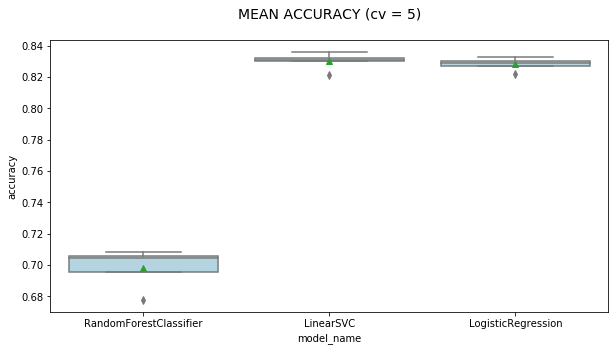

In [24]:
plt.figure(figsize=(10,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [25]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(tf_idf_svd, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [26]:
print("LinearSVC Accuracy :", accuracy_score(y_test, y_pred))

LinearSVC Accuracy : 0.8288


In [27]:
print('\t\t\t\tМетрики классификации\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Product'].unique()))

				Метрики классификации

                             precision    recall  f1-score   support

  Credit reporting or other       0.82      0.77      0.79      1103
            Debt collection       0.84      0.86      0.85      1860
Credit card or prepaid card       0.81      0.84      0.83       408
             Loans or other       0.85      0.87      0.86      1104
    Bank account or service       0.78      0.74      0.76       525

                   accuracy                           0.83      5000
                  macro avg       0.82      0.82      0.82      5000
               weighted avg       0.83      0.83      0.83      5000



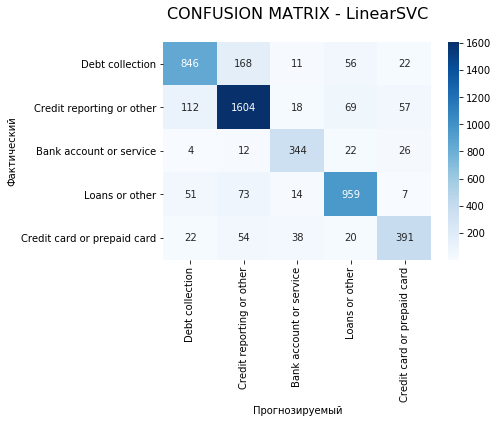

In [28]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Фактический')
plt.xlabel('Прогнозируемый')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [29]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' предсказанный как '{}' : {} случаев.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Consumer_complaint']])
      print('')

'Credit reporting or other' предсказанный как 'Debt collection' : 112 случаев.


,Product,Consumer_complaint
1270916,Credit reporting or other,check my account today luckily it now show de...
102838,Credit reporting or other,be contact on in of this year by debt recover...
1341726,Credit reporting or other,equifax there be few account on my report unve...
85879,Credit reporting or other,student loans company and report negative tra...
1560715,Credit reporting or other,be tell by in florida once this debt be pay o...
...,...,...
1322625,Credit reporting or other,damage my phone and return it to they claim t...
226773,Credit reporting or other,be contact on in of this year by say owe them...
1558563,Credit reporting or other,texas be try to collect money from me that be...
281558,Credit reporting or other,ftc violations the state of texas debtors be p...



'Loans or other' предсказанный как 'Debt collection' : 51 случаев.


,Product,Consumer_complaint
117911,Loans or other,have be try to work with the loan company nav...
1528151,Loans or other,be continually be call harass and threaten by...
34095,Loans or other,kia motors finance say that owe them debt but ...
406776,Loans or other,contact the debt collection agency regard loa...
1110251,Loans or other,receive an email from law firm yesterday stat...
1191555,Loans or other,lease vehicle from toyota in in the vehicle b...
1338826,Loans or other,attend school in be suppose to be release of ...
1174811,Loans or other,nationstar mortgage fraud and illegal debt col...
1335336,Loans or other,payment be not bein apply as should threaten p...
1411965,Loans or other,have revolve line of credit with cash financi...



'Credit card or prepaid card' предсказанный как 'Debt collection' : 22 случаев.


,Product,Consumer_complaint
1371139,Credit card or prepaid card,capital one and sell my account to debt collec...
145869,Credit card or prepaid card,this kind of account be place as charge off ac...
1328595,Credit card or prepaid card,sign up for an account and add automate payme...
1353255,Credit card or prepaid card,there be account that my mortgage loan officer...
1240279,Credit card or prepaid card,have jc penney credit card that be be service...
111100,Credit card or prepaid card,discover financial services show charge off on...
851051,Credit card or prepaid card,report that my macy credit car be steal and t...
1306600,Credit card or prepaid card,usaa do not follow procedures when they proces...
1202595,Credit card or prepaid card,have an account that fell past due very past ...
1297227,Credit card or prepaid card,do not know the category to select but this s...



'Debt collection' предсказанный как 'Credit reporting or other' : 168 случаев.


,Product,Consumer_complaint
514015,Debt collection,collection be report to all credit bureaus fo...
1374164,Debt collection,recently purchase copy of my credit report an...
53477,Debt collection,have law firm collect on the the debt have ma...
615682,Debt collection,there have be several account that have be ope...
1261951,Debt collection,this company be contact by me with an attempt ...
...,...,...
215025,Debt collection,the court do not report to any credit bureaus ...
90675,Debt collection,hello originally submit cfpb complaint on agai...
458025,Debt collection,make no effort to correct their errors and co...
1582161,Debt collection,creditor be report account that be invalid and...



'Loans or other' предсказанный как 'Credit reporting or other' : 73 случаев.


,Product,Consumer_complaint
1586038,Loans or other,have loan with have always make my payments o...
1419819,Loans or other,nelnet several account
456049,Loans or other,file dispute send through certify mail with o...
537950,Loans or other,purchase an auto mobile from auto masters in ...
1316953,Loans or other,have corporate auto loan with bank of america...
...,...,...
1356516,Loans or other,flagstar bank continue to show late pay histor...
120358,Loans or other,file bankruptcy in the bankruptcy do not incl...
854925,Loans or other,apply wit bmw for ease and loan my and report...
1472702,Loans or other,lender resmac inc nmls resmac be market as and...



'Credit card or prepaid card' предсказанный как 'Credit reporting or other' : 54 случаев.


,Product,Consumer_complaint
1363553,Credit card or prepaid card,credit line availability increase request on r...
1253039,Credit card or prepaid card,have an excellent credit history be home buil...
1246292,Credit card or prepaid card,have capital one security card that ve have f...
84944,Credit card or prepaid card,while apply for credit card offer with citiban...
730176,Credit card or prepaid card,on make balance payment due of cents to my cre...
230226,Credit card or prepaid card,at the present time be conduct an investigatio...
1374780,Credit card or prepaid card,have an hsbc credit card that be charge off i...
378764,Credit card or prepaid card,was caught up in travel debacle on different ...
1240339,Credit card or prepaid card,fraudulent credit card account be open in my ...
216524,Credit card or prepaid card,wells fargo bank close my secure credit card o...



'Credit card or prepaid card' предсказанный как 'Bank account or service' : 38 случаев.


,Product,Consumer_complaint
1324404,Credit card or prepaid card,be unknowingly make member of paypal credit p...
1241135,Credit card or prepaid card,receive western union net spend mastercard in...
159780,Credit card or prepaid card,to start of make purchase with use the prepay ...
214187,Credit card or prepaid card,hsbc approve my balance transfer request in th...
644124,Credit card or prepaid card,directexpress debit mastercard tx trying to st...
1487115,Credit card or prepaid card,this be the nd time chase bank have close my a...
1451366,Credit card or prepaid card,when make payments on the charge account at ba...
1258301,Credit card or prepaid card,made deposit on friday it have not load to my ...
1313334,Credit card or prepaid card,on receive response from wells fargo about my ...
473131,Credit card or prepaid card,on call to pay in full the balance on my secur...



'Debt collection' предсказанный как 'Loans or other' : 56 случаев.


,Product,Consumer_complaint
291558,Debt collection,have do last year and take advantage of zero ...
477088,Debt collection,have try again and again to try to get help w...
1225349,Debt collection,we fell behind on payment or two on auto loan ...
1257186,Debt collection,have vehemently contest the wrongful foreclos...
1216993,Debt collection,have credit card that be include in discharge...
1469231,Debt collection,years ago they take all the money out of our a...
1600563,Debt collection,in purchase vehicle from about two weeks later...
575988,Debt collection,have resolve debt in full it be file in the c...
126906,Debt collection,despite my verbal request to communicate with ...
1200589,Debt collection,due to medical issue be force to quit my job c...



'Credit reporting or other' предсказанный как 'Loans or other' : 69 случаев.


,Product,Consumer_complaint
64002,Credit reporting or other,purchase vehicle in of and acquire loan throu...
1572184,Credit reporting or other,after dismiss an adversary proceed be tell by ...
877525,Credit reporting or other,make my payments on time with the company in ...
637523,Credit reporting or other,strategic automotive transfer my auto loan wit...
97533,Credit reporting or other,go to this loan officer to cause the young la...
...,...,...
391795,Credit reporting or other,online store amazonstorecard com use unethica...
294677,Credit reporting or other,filed for an income drive repayment plan in fe...
1574211,Credit reporting or other,dispute complaint summary report that do not p...
152715,Credit reporting or other,refuse to mark our mortgage payment as make t...



'Bank account or service' предсказанный как 'Loans or other' : 22 случаев.


,Product,Consumer_complaint
695849,Bank account or service,had insurance protection on all my loan in cas...
66958,Bank account or service,this have to do with the class action lawsuit ...
160569,Bank account or service,ally bank change the limit for transfer money ...
1562443,Bank account or service,have cd with synchrony bank that be schedule ...
159973,Bank account or service,on at pay my monthly payment on my usaa renter...
1413077,Bank account or service,violated the dodd frank act on me and allowed...
1298675,Bank account or service,in of when open by bank statement find that ha...
439910,Bank account or service,make timely payment on my online bank on to f...
1221853,Bank account or service,commerce bank the lender for buyer have requir...
1410430,Bank account or service,this person that say they be sell puppy and th...



'Credit card or prepaid card' предсказанный как 'Loans or other' : 20 случаев.


,Product,Consumer_complaint
1258848,Credit card or prepaid card,two respresentatives schedule unauthorized con...
1580905,Credit card or prepaid card,about three years ago my wife become and apply...
1324086,Credit card or prepaid card,target corp have act in an unfair hostile and ...
1194016,Credit card or prepaid card,the company cancel credit protection on my acc...
816886,Credit card or prepaid card,have submit complaint on cfpb no request assi...
1329345,Credit card or prepaid card,call macy cs in to make sure my auto payments...
1208099,Credit card or prepaid card,chase contact me and be offer pay reduction in...
395472,Credit card or prepaid card,have fund debit from my paycheck to fund flex...
1579320,Credit card or prepaid card,apply for the barclays black card back in be ...
1344439,Credit card or prepaid card,have send numerous letter with no response



'Debt collection' предсказанный как 'Credit card or prepaid card' : 22 случаев.


,Product,Consumer_complaint
1245192,Debt collection,ebay flood inboxes with offer to sell for free...
1188375,Debt collection,when go to refinance my home be tell that disc...
1544529,Debt collection,first become aware that there be credit card ...
223168,Debt collection,be still have difficulty deal with and secure...
1499182,Debt collection,this card be pay off in and then someone use i...
1212274,Debt collection,have card with this company but close it back...
200861,Debt collection,purchase cosmetic bag and body products at on...
162080,Debt collection,have secure credit card with well fargo that ...
1563349,Debt collection,received call from debt collectors concern mon...
1522620,Debt collection,total amount owe total amount owe charge off ...



'Credit reporting or other' предсказанный как 'Credit card or prepaid card' : 57 случаев.


,Product,Consumer_complaint
1453178,Credit reporting or other,apply for credit card with american express a...
1497586,Credit reporting or other,on summon be deliver regard credit card with b...
351190,Credit reporting or other,this particular account situation that be late...
1433289,Credit reporting or other,hello have already try to deal with this throu...
446114,Credit reporting or other,home depot credit service call on say payment ...
188627,Credit reporting or other,be shock when review my credit report and fin...
143994,Credit reporting or other,synchrony bank walmart credit card account num...
38648,Credit reporting or other,credit card with walmart say be not pay but cl...
1271737,Credit reporting or other,it have be bring to my attention that have acc...
69860,Credit reporting or other,be year old private client of for over years ...



'Bank account or service' предсказанный как 'Credit card or prepaid card' : 26 случаев.


,Product,Consumer_complaint
94533,Bank account or service,using the cash app accidentally send money to ...
411250,Bank account or service,on charge for be bill to my debit card for do ...
244066,Bank account or service,as prefer reward member with bank of america v...
142130,Bank account or service,on call in tdbank for support for dispute char...
243969,Bank account or service,purchase gift card google play card and googl...
355742,Bank account or service,have be try to have my account unfreeze and h...
1250381,Bank account or service,contact chase to inform them that dispute the...
473509,Bank account or service,in dispute charge they say it would be credit ...
378909,Bank account or service,spoke with american express an they said that ...
1356686,Bank account or service,on swipe my card to pump gas at shell locate a...


In [30]:
X_train, X_test, y_train, y_test = train_test_split(df2['Consumer_complaint'], labels, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [31]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(df2.Product.unique()[model.predict(fitted_vectorizer.transform([new_complaint]))])

['Loans or other']


In [32]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(df2.Product.unique()[model.predict(fitted_vectorizer.transform([new_complaint_2]))])

['Debt collection']
